In [1]:
import os

os.chdir('../')
os.getcwd()

'/home/bitwalk/PycharmProjects/stock-explorer'

In [2]:
import pickle

pkl_df_base = 'pool/df_base_1698710400.pkl'
with open(pkl_df_base, 'rb') as f:
    df_base_all = pickle.load(f)
print(df_base_all)

            1_open  1_high   1_low  1_close  2_open      2_high       2_low  \
1640217600  3060.0  3065.0  3045.0   3050.0   544.0  549.000000  542.000000   
1640304000  3050.0  3050.0  3025.0   3025.0   543.0  545.000000  540.000000   
1640563200  3040.0  3045.0  3030.0   3035.0   541.0  543.000000  537.000000   
1640649600  3040.0  3095.0  3035.0   3095.0   541.0  549.000000  539.000000   
1640736000  3085.0  3100.0  3065.0   3100.0   545.0  553.000000  545.000000   
...            ...     ...     ...      ...     ...         ...         ...   
1695254400  3990.0  4020.0  3970.0   3970.0   752.0  758.200012  746.500000   
1695340800  3955.0  3970.0  3930.0   3950.0   746.5  747.799988  737.500000   
1695600000  3950.0  4000.0  3950.0   3995.0   737.5  742.500000  733.500000   
1695686400  3970.0  4015.0  3970.0   3990.0   739.5  746.099976  735.400024   
1695772800  3975.0  4025.0  3940.0   4020.0   750.0  753.000000  743.599976   

               2_close  3_open  3_high  ...  3816_l

In [3]:
import datetime as dt
import pandas as pd

from functions.conv_timestamp2date import conv_timestamp
from functions.get_dict_code import get_dict_code
from functions.predict_price import get_prediction_by_pls_2
from functions.resources import get_connection
from functions.trading_date import get_next_trading_date

pkl_df_pred = 'pool/df_pred_1698710400.pkl'
columns_summary_code = ['Components', 'RMSE', 'R2', 'Open']
df_pred = pd.DataFrame(columns=columns_summary_code)

day1 = 60 * 60 * 24
year = day1 * 365
index_date = df_base_all.index
# 1695772800
date_last = index_date[len(index_date) - 1]

con = get_connection()
if con.open():
    # prepare dictionary for id_code and code
    dict_code: dict = get_dict_code()
    con.close()

target_id_code = 24
for start in index_date:
    end = start + year
    end_next = get_next_trading_date(end)
    print(conv_timestamp(start), conv_timestamp(end), conv_timestamp(end_next))
    index_scope = index_date[(start <= index_date) & (index_date <= end)]
    df_base = df_base_all.loc[index_scope]
    series_fitting = get_prediction_by_pls_2(df_base, dict_code, target_id_code)
    df_pred.loc[end_next] = series_fitting
    print(df_pred)

    if end >= date_last:
        break

pkl_df_pred = 'pool/df_pred_1698710400.pkl'
with open(pkl_df_pred, 'wb') as f:
    pickle.dump(df_pred, f)

print('Completed!')
print(df_pred)

qt.core.qobject.connect: QObject::connect(QObject, Unknown): invalid nullptr parameter


2021-12-23 00:00:00 2022-12-23 00:00:00 2022-12-26 00:00:00
30% completed

KeyboardInterrupt: 

In [14]:
import pickle

with open(pkl_df_pred, 'rb') as f:
    df_pred = pickle.load(f)
list_x_pred = [conv_timestamp(x) for x in df_pred.index]
list_y_pred = list(df_pred['Open'])

In [44]:
from PySide6.QtSql import QSqlQuery

list_x = list()
list_y = list()

con = get_connection()
if con.open():
    sql = """
        SELECT date, open FROM trade
        WHERE id_code=%d
        ORDER BY date;
    """ % target_id_code
    query = QSqlQuery(sql)
    while query.next():
        x = query.value(0)
        d = conv_timestamp(x)
        if d in list_x_pred:
            list_x.append(d)
            list_y.append(query.value(1))
    con.close()

list_x_pred2 = list()
list_y_pred2 = list()

for d in list_x:
    #print(d)
    if d in list_x_pred:
        idx = list_x_pred.index(d)
        list_x_pred2.append(list_x_pred[idx])
        list_y_pred2.append(list_y_pred[idx])

print(len(list_x), len(list_x_pred2))
list_x_pred = list_x_pred2
list_y_pred = list_y_pred2

149 149


In [45]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

FONT_PATH = 'fonts/RictyDiminished-Regular.ttf'
fm.fontManager.addfont(FONT_PATH)
font_prop = fm.FontProperties(fname=FONT_PATH)

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 24

36.501448268140585


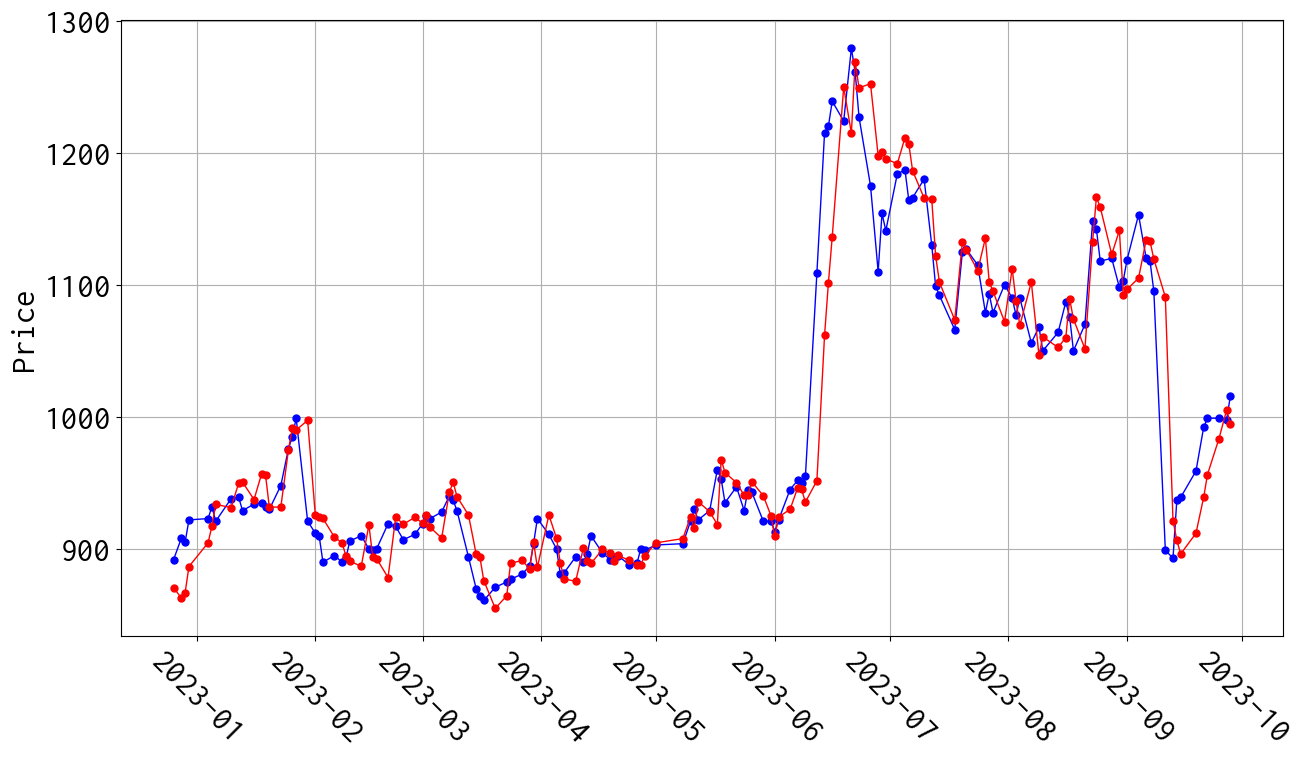

In [47]:
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(list_y, list_y_pred, squared=False)
print(rmse)

fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot()

ax.plot(
    list_x,
    list_y,
    color='blue',
    marker='o',
    markersize=5,
    linewidth=1
)
ax.plot(
    list_x_pred,
    list_y_pred,
    color='red',
    marker='o',
    markersize=5,
    linewidth=1
)

plt.xticks(rotation=315)
ax.set_ylabel('Price')
plt.grid()
 
plt.show()